## Carga de librerias


In [ ]:
! python -m pip install --upgrade pip
! pip install keras
! pip install tensorflow
! pip install mlxtend

In [1]:
### General
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_validate
import math
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
import tensorflow as tf

### Error
## ECM
from sklearn.metrics import mean_squared_error
## Coeficiente de determinacion
from sklearn.metrics import r2_score
## Varianza explicada
from sklearn.metrics import explained_variance_score
## Naive Bayes 
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
## KNN
from sklearn.neighbors import KNeighborsClassifier
### Redes Neuronales Artificiales
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
### Random Forest
from sklearn.ensemble import RandomForestClassifier
### Vectores de soporte
from sklearn import svm

### PCA
from mlxtend.feature_extraction import PrincipalComponentAnalysis as PCA


Using TensorFlow backend.


## Carga de la base de datos

#### Características: 
- Variables de entrada:
 - ##### Datos del cliente del banco:
   1. age (numérica)
   2. job : tipo de empleo (categórica: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",     "blue-collar","self-employed","retired","technician","services") 
   3. marital : estado civil (categórica: "married","divorced","single"; nota: "divorced" aplica para divorciado o viudo)
   4. education (categórica: "unknown","secondary","primary","tertiary")
   5. default: tiene credito? (binaria: "yes","no")
   6. balance: promedio de saldo anual en euros (numérica) 
   7. housing: tiene crédito de vivienda? (binaria: "yes","no")
   8. loan: tiene crédito personal? (binaria: "yes","no")
 - ##### Datos del último contacto en relación a la actual campaña:
   9. contact: tipo de comunicación (categórica: "unknown","telephone","cellular") 
   10. day: último día de contacto en el mes (numérica)
   11. month: último mes de contacto del año (categórica: "jan", "feb", "mar", ..., "nov", "dec")
   12. duration: última duración de contacto en segundos (numérica)
 - ##### Otros atributos:
   13. campaign: número de contactos realizados durante la campaña para este cliente (numérica, incluye último contacto)
   14. pdays: número de dias que pasaron después de que el cliente fué contactado desde una campaña anterior (numérica, -1 significa que el cliente no había sido previamente contactado)
   15. previous: número de contactos realizados antes de la campaña actual para este cliente (numérica)
   16. poutcome: resultado de la campaña anterior (categórica: "unknown","other","failure","success")
   
   
- Variable de salida (objetivo deseado):

   17. y: se suscribió el cliente al depósito a término fijo? (binaria: "yes","no")


- Datos faltantes: nunguno

In [2]:
dataset = pd.read_csv("data/bank.csv", delimiter=";",header='infer')

data = dataset.iloc[:, :-1]
target = dataset.iloc[:,-1]

binary_cols = ['default', 'housing', 'loan']
numerical_cols = ['age', 'balance', 'day', 'duration', 
                  'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'contact',
                    'month', 'poutcome']

label_encoder = LabelEncoder()

data[binary_cols] = data[binary_cols].apply(lambda col: label_encoder.fit_transform(col))

column_trasformer = ColumnTransformer( transformers=[('ss', StandardScaler(), numerical_cols),
                                                     ('ohe', OneHotEncoder(sparse=False), categorical_cols)],
                                      remainder='passthrough')

data_encoded = column_trasformer.fit_transform(data)

print(data_encoded.shape)

# Convertir salida a binario
target_label_encoder = LabelEncoder()

target = target_label_encoder.fit_transform(target)

# Dividir en conjuntos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(data_encoded, target, test_size=0.1) # 90% training and 10% test



(4521, 48)


/home/daemonsoft/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/daemonsoft/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Principal Component Analysis

In [13]:
pca = PCA(n_components=10)
data_encoded = pca.fit(data_encoded).transform(data_encoded)
print(data_encoded.shape)

# Dividir en conjuntos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(data_encoded, target, test_size=0.1) # 90% training and 10% test




(4521, 10)


## Naive Bayes

In [6]:
## Naive Bayes 
gnb = GaussianNB()

gnb_pred = gnb.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (y_test != gnb_pred).sum(),
          100*(1-(y_test != gnb_pred).sum()/X_test.shape[0])
))

Number of mislabeled points out of a total 453 points : 51, performance 88.74%


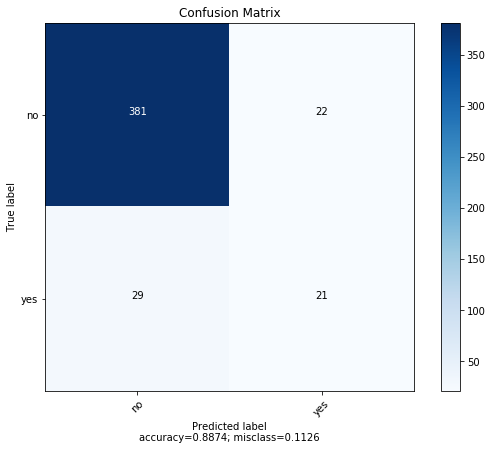

In [9]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, gnb_pred)

plot_confusion_matrix(cm, normalize    = False,
                      target_names = ['no', 'yes'],
                      title        = "Confusion Matrix")

## KNN

In [10]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, knn_pred))

Accuracy: 0.8962472406181016


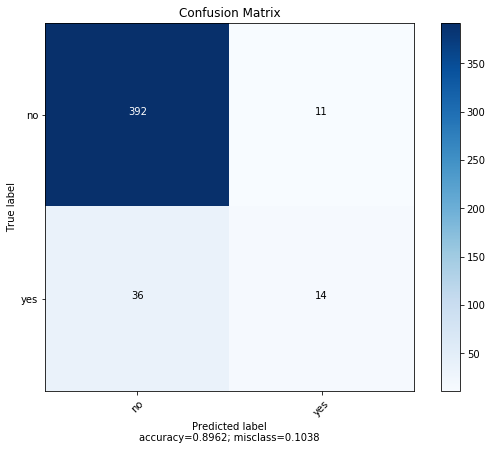

In [11]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, knn_pred)
plot_confusion_matrix(cm, normalize    = False,
                      target_names = ['no', 'yes'],
                      title        = "Confusion Matrix")

## RNA

In [12]:
rna = Sequential()

# Add an input layer 
rna.add(Dense(24, activation='relu', input_shape=(48,)))

# Add an hidden layer 
rna.add(Dense(24, activation='relu'))

# Add an output layer 
rna.add(Dense(1, activation='sigmoid'))

# For a binary classification problem
rna.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

rna.fit(X_train, y_train, 
        validation_data=(X_test, y_test),
        batch_size = 10,
        epochs=100,
        verbose=2)
score = rna.evaluate(X_test, y_test)
print('Score: ', score)


Instructions for updating:
Colocations handled automatically by placer.


ValueError: Error when checking input: expected dense_1_input to have shape (48,) but got array with shape (10,)

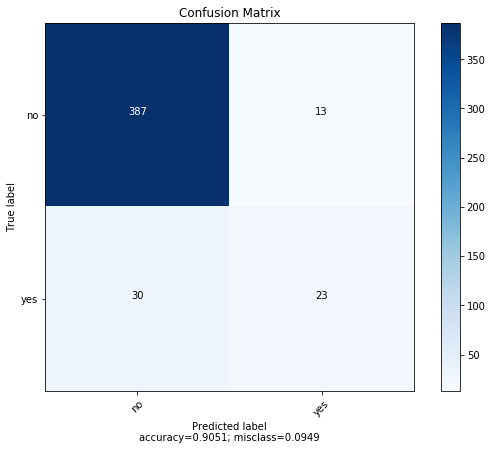

In [175]:
rna_pred = rna.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, rna_pred.round())
plot_confusion_matrix(cm, normalize    = False,
                      target_names = ['no', 'yes'],
                      title        = "Confusion Matrix")


## Random Forest

In [176]:
rfc = RandomForestClassifier(n_estimators=10, criterion='entropy')

#train model
rfc.fit(X_train, y_train)

print('Score: ', rfc.score(X_train, y_train))

Score:  0.98992133726647


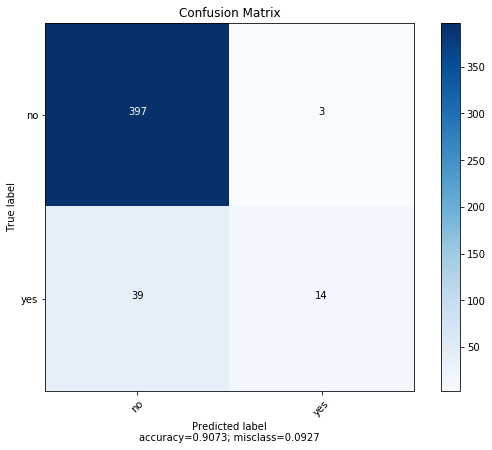

Accuracy: 0.9072847682119205
0.8933150191452774 0.9905358027978327
Score:  [0.6293533822032263, 0.9050772628247343]


In [177]:
rfc_pred = rfc.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, rfc_pred)
plot_confusion_matrix(cm, normalize    = False,
                      target_names = ['no', 'yes'],
                      title        = "Confusion Matrix")

print("Accuracy:", accuracy_score(y_test, rfc_pred))

rfc_results = cross_validate(rfc, X_train, y_train, cv=5, return_train_score=True)
print(np.mean(rfc_results['test_score']), np.mean(rfc_results['train_score']))
print('Score: ', score)



## Maquinas de Soporte Vectorial con kernel lineal y con kernel RBF

In [26]:
# Lineal

linear = svm.SVC(C=1, kernel='linear')
linear.fit(X_train, y_train)
print('Score: ', linear.score(X_train, y_train))


Score:  0.8952802359882006


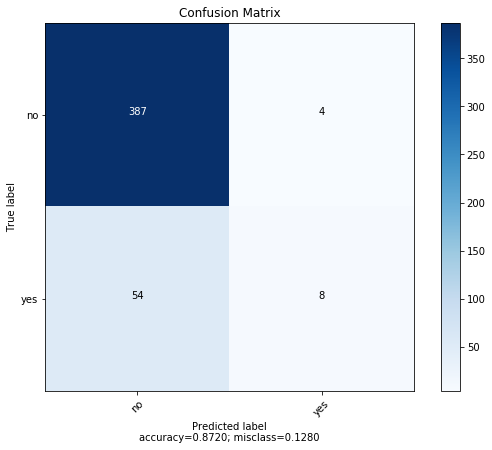

In [27]:
linear_pred = linear.predict(X_test)
# Making the Confusion Matrix
cm = confusion_matrix(y_test, linear_pred)
plot_confusion_matrix(cm, normalize    = False,
                      target_names = ['no', 'yes'],
                      title        = "Confusion Matrix")

In [28]:
#RBF

rbf = svm.SVC(C=1, kernel='rbf', gamma='auto')
rbf.fit(X_train, y_train)
print('Score: ', rbf.score(X_train, y_train))


Score:  0.9041297935103245


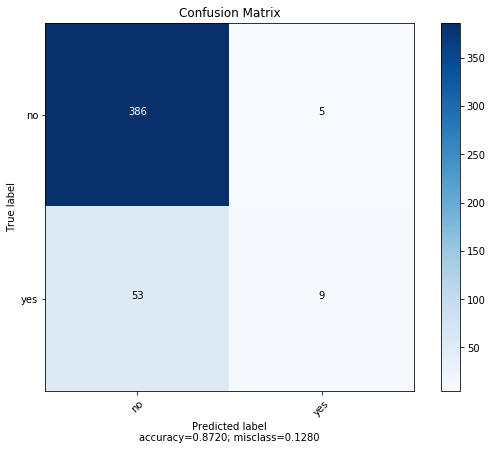

In [30]:
rbf_pred = rbf.predict(X_test)
# Making the Confusion Matrix
cm = confusion_matrix(y_test, rbf_pred)
plot_confusion_matrix(cm, normalize    = False,
                      target_names = ['no', 'yes'],
                      title        = "Confusion Matrix")

#### Confusion Matrix

In [8]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()